In [1]:
!pip install pandas numpy yfinance statsmodels scikit-learn keras matplotlib vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 4.4 MB/s eta 0:00:00


In [2]:
# **************** IMPORT PACKAGES ********************
import yfinance as yf
import requests
import csv
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import os
import math
import warnings
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
from datetime import datetime,timedelta
from alpha_vantage.timeseries import TimeSeries
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from statsmodels.tsa.arima.model import ARIMA
from pandas.tseries.offsets import BDay  # For business days

In [3]:
def download_stock_data(ticker):
    """Downloads historical stock data from Yahoo Finance and saves it to a CSV file.

    Args:
        ticker: The stock ticker symbol (e.g., 'AAPL').
    """
    try:
        # Download data using yfinance
        end = datetime.now()
        start = datetime(end.year - 4, end.month, end.day)
        data = yf.download(ticker, start=start, end=end)
        # Save data to CSV file
        data.to_csv(f'{ticker}.csv')
        print(f"\nData for {ticker} downloaded and saved to {ticker}.csv")
    except Exception as e:
        print(f"Error downloading data for {ticker}: {e}")

# Example usage
ticker = "HDFCBANK.NS"
# ticker = "TATAMOTORS.NS"
download_stock_data(ticker)

[*********************100%***********************]  1 of 1 completed


Data for HDFCBANK.NS downloaded and saved to HDFCBANK.NS.csv


In [4]:
# Load the CSV data into a pandas DataFrame
df = pd.read_csv('HDFCBANK.NS.csv')
# df = pd.read_csv('TATAMOTORS.NS.csv')
df.columns=["Date","Adj Close","Close","High","Low","Open","volume"]
df.drop(0,axis=0,inplace=True)
df.drop(1,axis=0,inplace=True)
df.to_csv('HDFCBANK.NS.csv', index=False)
# df.to_csv('TATAMOTORS.NS.csv', index=False)

In [5]:
df=pd.read_csv('HDFCBANK.NS.csv')
# df=pd.read_csv('TATAMOTORS.NS.csv')

In [6]:
# Ensure date is parsed correctly
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by='Date')

# Feature columns and target
features = ["Adj Close", "Close", "High", "Low", "Open", "volume"]
target = "Close"

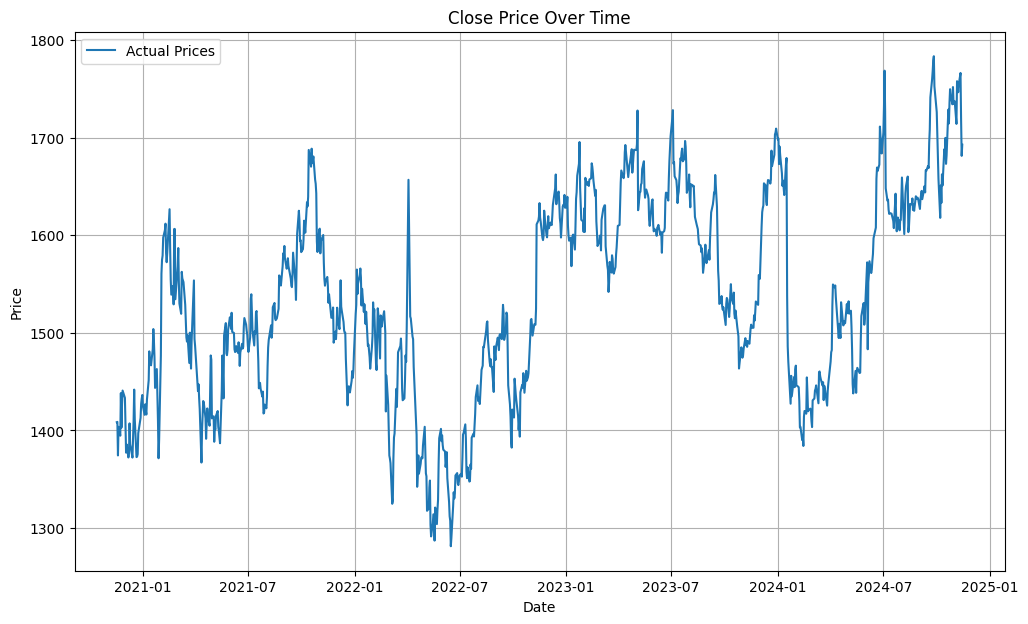

In [7]:
# Customize the plot
plt.figure(figsize=(12, 7))
plt.plot(df['Date'], df['Close'], label='Actual Prices')

plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Close Price Over Time")
plt.grid(True)
plt.legend()

# Display the plot
plt.show()

In [8]:
def fetch_tweets(query, cursor=None):
    url = "https://twitter-api45.p.rapidapi.com/search.php"
    headers = {
        "x-rapidapi-key": "4ec154cc17mshfb1a17a88a74772p159e36jsn6467a42c7d46",
        "x-rapidapi-host": "twitter-api45.p.rapidapi.com"
    }
    querystring = {"query": query, "search_type": "Latest"}
    if cursor:
        querystring["cursor"] = cursor

    response = requests.get(url, headers=headers, params=querystring)
    if response.status_code == 200:
        data = response.json()
        return data.get("timeline", []), data.get("next_cursor")
    else:
        print(f"Error: {response.status_code}")
        return [], None

def analyze_tweet_sentiment(tweets):
    analyzer = SentimentIntensityAnalyzer()
    global_polarity = 0
    positive_count = negative_count = 0

    for tweet in tweets:
        text = tweet.get("text", "")
        sentiment_score = analyzer.polarity_scores(text)
        global_polarity += sentiment_score["compound"]

        if sentiment_score["compound"] >= 0.05:
            positive_count += 1
        elif sentiment_score["compound"] <= -0.05:
            negative_count += 1

    return global_polarity, positive_count, negative_count

def get_recommendation(positive_count, neutral_count, negative_count):
    if positive_count > negative_count and positive_count > neutral_count:
        return "Buy"
    elif negative_count > positive_count and negative_count > neutral_count:
        return "Sell"
    else:
        return "Hold"

def retrieve_tweets_polarity(symbol):
    # Load stock ticker mapping
    stock_ticker_map = pd.read_csv('Yahoo-Finance-Ticker-Symbols.csv')
    symbol_name = stock_ticker_map[stock_ticker_map['Ticker'] == symbol]['Name'].values[0]

    print(f"Fetching tweets for {symbol_name}...")
    all_tweets = []
    cursor = None
    api_call_count = 0

    # Fetch tweets with a limit of 5 API calls
    while api_call_count < 5:
        tweets, cursor = fetch_tweets(f"{symbol_name}", cursor)

        if not tweets:
            break
        all_tweets.extend(tweets)
        api_call_count += 1
        if not cursor:
            break

    if not all_tweets:
        print("No tweets found for this symbol.")
        return

    # Analyze the sentiment of the fetched tweets
    global_polarity, positive_count, negative_count = analyze_tweet_sentiment(all_tweets)
    total_tweets = len(all_tweets)
    neutral_count = total_tweets - positive_count - negative_count

    # Calculate percentages
    positive_percentage = (positive_count / total_tweets) * 100
    neutral_percentage = (neutral_count / total_tweets) * 100
    negative_percentage = (negative_count / total_tweets) * 100

    print(f"Global Polarity: {global_polarity}")
    print(f"Positive Tweets: {positive_count} ({positive_percentage:.2f}%)")
    print(f"Neutral Tweets: {neutral_count} ({neutral_percentage:.2f}%)")
    print(f"Negative Tweets: {negative_count} ({negative_percentage:.2f}%)")
    print(f"Total Tweets: {total_tweets}")

    # Determine recommendation based on sentiment
    recommendation = get_recommendation(positive_count, neutral_count, negative_count)
    print(f"Recommendation: {recommendation}")

In [9]:
def LSTM_All_Features(df, forecast_days=7):
    # Normalize the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df[features])
    sequence_length = 7  # Use 7 days of history to predict the next day
    X, y = [], []

    for i in range(sequence_length, len(scaled_data)):
        X.append(scaled_data[i-sequence_length:i])
        y.append(scaled_data[i, features.index(target)])

    X, y = np.array(X), np.array(y)

    # Split the data into training and testing sets
    train_size = int(len(X) * 0.65)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))  # Dropout with a rate of 0.2
    model.add(LSTM(50, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(50))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')

    model.summary()

    model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

    # Predict future prices
    future_prices = []
    last_sequence = scaled_data[-sequence_length:]  # Last sequence from the scaled data (shape: 7x6)

    for _ in range(forecast_days):  # Predict for `forecast_days`
        # Predict the next value using the current sequence
        prediction = model.predict(last_sequence[np.newaxis, :, :])  # Shape: (1, 1)
        prediction_value = prediction[0, 0]  # Extract the single predicted value

        # Store the predicted value for output
        future_prices.append(prediction_value)

        # Create a new row with the same number of features
        new_row = np.zeros(last_sequence.shape[1])  # Shape: (6,)
        new_row[features.index(target)] = prediction_value  # Insert prediction at the target feature index

        # Update the sequence: remove the first row, add the new row
        last_sequence = np.vstack([last_sequence[1:], new_row])  # Shape: (7, 6)

    # Rescale the predictions back to the original scale
    future_prices = scaler.inverse_transform([[p if i == features.index(target) else 0 for i in range(len(features))]
                                              for p in future_prices])[:, features.index(target)]

    # Generate future business dates (working days)
    last_date = df['Date'].iloc[-1]
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_days, freq="B")

    # Plot the results
    plt.figure(figsize=(14, 7))
    plt.plot(future_dates, future_prices, label='Predicted Prices', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title('Stock Price Prediction')
    plt.legend()
    plt.grid()
    plt.show()

    # Plot the results
    plt.figure(figsize=(14, 7))
    plt.plot(df['Date'], df['Close'], label='Actual Prices')
    plt.plot(future_dates, future_prices, label='Predicted Prices', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title('Stock Price Prediction')
    plt.legend()
    plt.grid()
    plt.show()

    # Output future predictions
    for date, price in zip(future_dates, future_prices):
        print(f"{date.date()}: {price:.2f}")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 7, 50)               │          11,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 7, 50)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 7, 50)               │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 7, 50)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 51,851 (202.54 KB)

 Trainable params: 51,851 (202.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 141ms/step - loss: 0.1401 - val_loss: 0.0160
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0169 - val_loss: 0.0096
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0127 - val_loss: 0.0081
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0097 - val_loss: 0.0087
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0094 - val_loss: 0.0076
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0095 - val_loss: 0.0077
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0092 - val_loss: 0.0072
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0098 - val_loss: 0.0082
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0093 - val_loss: 0.0070
Epoch 10/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0084 - val_loss: 0.0068
Epoch 11/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0085 - val_loss: 0.0071
Epoch 12/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/st

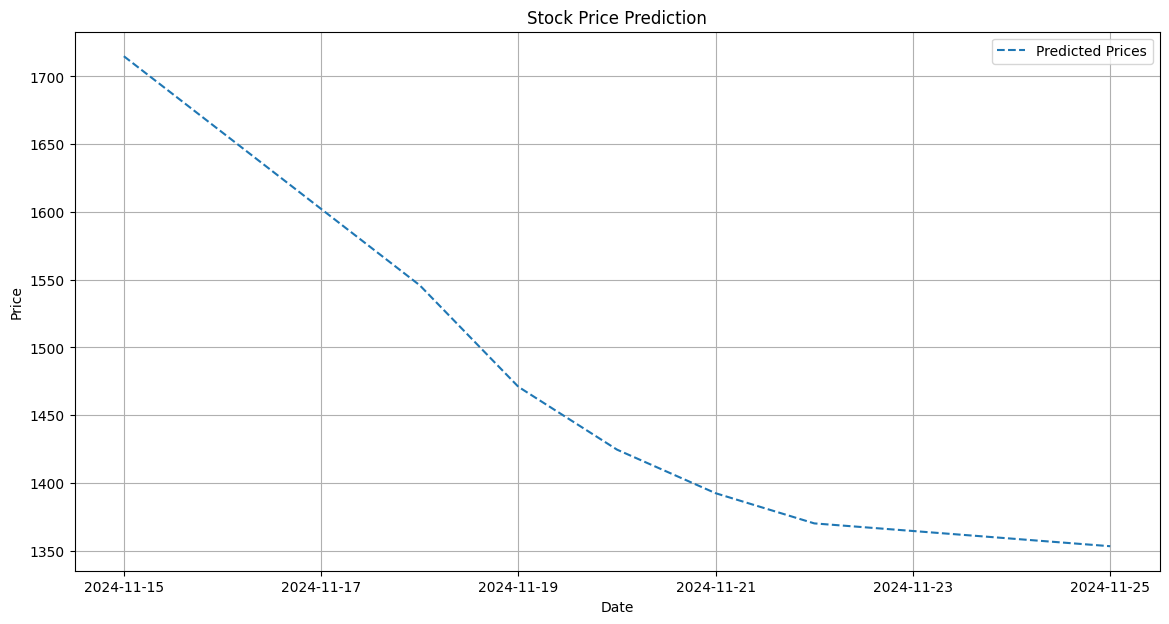

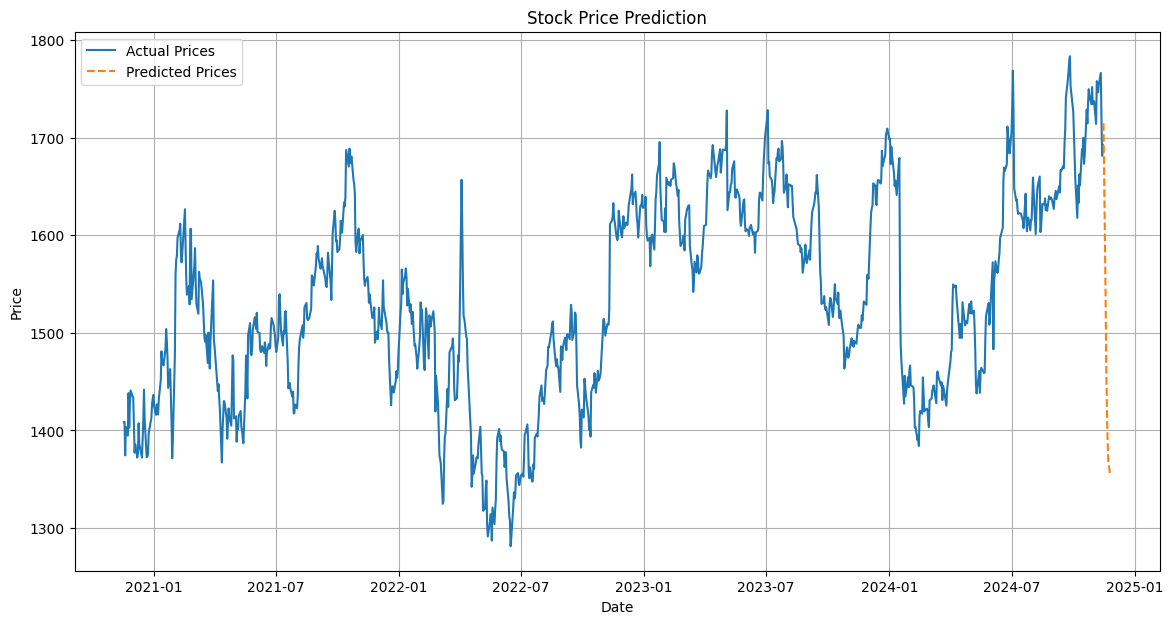

2024-11-15: 1714.89
2024-11-18: 1545.87
2024-11-19: 1470.96
2024-11-20: 1424.59
2024-11-21: 1392.43
2024-11-22: 1370.16
2024-11-25: 1353.32


In [10]:
LSTM_All_Features(df)

In [11]:
retrieve_tweets_polarity("HDFCBANK.NS")

Fetching tweets for HDFC Bank Limited...
Global Polarity: 11.818999999999999
Positive Tweets: 38 (65.52%)
Neutral Tweets: 7 (12.07%)
Negative Tweets: 13 (22.41%)
Total Tweets: 58
Recommendation: Buy
